# Analyser

Der er et ønske om at forudsige om en kunde er på vej til at ud af døren så man gøre noget aktivt før kunden forlader butikken.

Det lader til at de data som jeg har fået er fra Kaggle: https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

## Data

Mål med at kigge på dataene er:
- Håndter manglende værdier
- Handter underlige værdier/outliers
- Hvordan hænger de forskellige features sammen?
- Håndtering af balance?

Filen er ikke så stor så vi kan sagtens hente al data ind i hukommelsen vha. Pandas.

- Overvej hvad vil man gøre når data er for stor.
   - Pandas kan sagtens håndtere data som fylder omkring 1GB
   - Hvis det fylder mere skal kigge på hukommelsesforbruget.
     - Man kan bruge `pd.read_csv(.., chunksize=100000)` - antallet af rækker der skal processeres ad gangen. Husk at man får ikke end DataFrame
     - Brug andre data typer for kolonnerne. Færre bits kræver mindre RAM.

In [2]:
df_data = pd.read_csv('data.csv', index_col=0) # Default Pandas starte sit index på 0

In [3]:
df_data.head()

,UserId,LastName,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,Salary,Churned
Index,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df_data.shape

(10000, 13)

Hvor mange unikke kunder?

In [5]:
df_data['UserId'].nunique()

10000

### Manglede værdier

Manglende værdier er tit et problem når man sidder med data i den virkelig verden.

In [6]:
df_missing = pd.DataFrame(df_data.isnull().sum(), columns=['Manglende Værdier']).T

In [7]:
df_missing

,UserId,LastName,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,Salary,Churned
Manglende Værdier,0,0,0,0,0,0,0,0,0,0,0,0,0


Umiddelbare tanker:
- Havde forventet at der var nogle manglede værdier. Data virker renset.

Ved manglende værdier har man flg. muligheder:

- Slette dem med `df_data.dropna(axis=0, thresh=5)`. Vær forsigtig. Kig evt. på andelen af manglende værdier.
- Udfylde dem med f.eks.
  - Gennemsnitsværdi `df_data['Salary'].fillna(value=df_data['Salary'].mean())`. Godt til kontinuerlig data uden outliers.
  - Medianen: Godt kontinuerlig data med outliers.
  - Mode: Flest forekommmende værdi. Godt for kategorisk kolonne.



Igen man skal være forsigtigt med at udfylde data med statistikker fordi disse påvirker korrelationen mellem to variabler.

> Please note that Mean, Median and Mode imputation diminishes any correlations involving the variable(s) that are imputed. This is because we assume that there is no relationship between the imputed variable and any other measured variables. Thus, those imputations have some attractive properties for univariate analysis but become problematic for multivariate analysis. [https://medium.com/@george.drakos62/handling-missing-values-in-machine-learning-part-1-dda69d4f88ca]

> Although imputing missing values by using the mean is a popular imputation technique, there are serious problems with mean imputation. The variance of a mean-imputed variable is always biased downward from the variance of the un-imputed variable. This bias affects standard errors, confidence intervals, and other inferential statistics. Experts agree that mean imputation should be avoided when possible (Allison (2009), Horton and Kleinman (2007)). [https://blogs.sas.com/content/iml/2017/12/06/problems-mean-imputation.html]

In [8]:
categorical_features = ['Geography', 'Gender']
boolean_features = ['HasCreditCard', 'IsActiveMember']
continuous_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'Salary']

### Tjek for mærkelige værdier

Undersøger om der er underlige værdier i dataene. Lad os kigge på de kontinuerte features:

In [9]:
df_data[continuous_features].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,Salary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


Her undersøger jeg om der er nogle unormale værdier og få en fornemmelse af om værdierne giver mening.

Umiddelbare noter:
- **CreditScore**: Mangler information omkring denne feature. Antager data er fra et europæisk bank. Kan ikke finde noget info omkring dette. Interval fra 350 til 850. Passer nogenlunde med [amerikansk FICO](https://en.wikipedia.org/wiki/Credit_score) hvor credit score er fra 300 til 850.
- **Age**: kunderne er fra 18 til 92. Ikke noget mærkeligt.
- **Tenure**: varierer fra 0 til 10. Om det er måneder eller år er ukendt?
- **Balance**: Antager det er EUR. 250.898 EUR virker et meget højt beløb, men det er vel ikke unormalt.
- **NumOfProducts**: antager at dette er antallet af bankydelser som kunden har haft på det tidspunkt data er blevet udtrukket.
- **Salary**: løn plejer at variere fra år til år.

Det er tydeligt at datasættet er et snapshot af kundesituationen i en bank. Kender dog ikke perioden. 

In [10]:
df_data.sort_values('Balance', ascending=False)

,UserId,LastName,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,Salary,Churned
Index,,,,,,,,,,,,,
2093,15757408,Lo,655,Spain,Male,38,3,250898.09,3,0,1,81054.00,1
3281,15715622,To Rot,583,France,Female,57,3,238387.56,1,0,1,147964.99,1
8734,15714241,Haddon,749,Spain,Male,42,9,222267.63,1,0,0,101108.85,1
3589,15571958,McIntosh,489,Spain,Male,40,3,221532.80,1,1,0,171867.08,0
6718,15586674,Shaw,663,Spain,Female,58,5,216109.88,1,0,1,74176.71,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7137,15689781,Ts'ai,826,France,Female,49,0,0.00,1,0,0,178709.98,1
830,15639788,Yuan,577,France,Female,39,10,0.00,2,1,0,10553.31,0
7140,15805212,Black,806,France,Female,67,1,0.00,2,0,1,103945.58,0


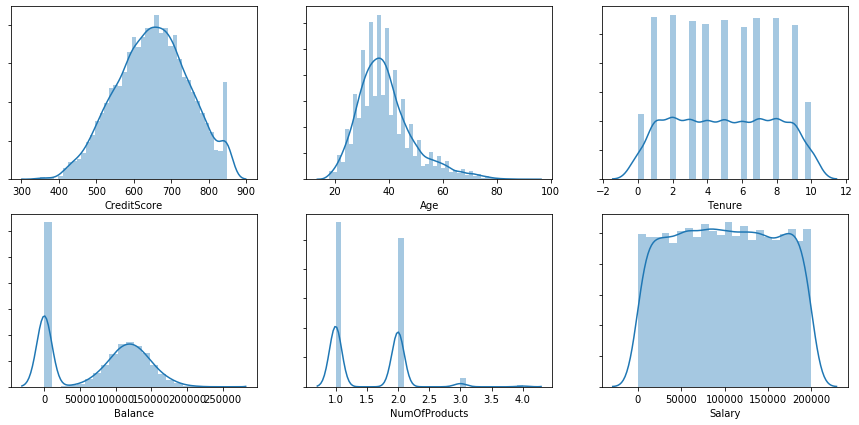

In [11]:
fig, ax = plt.subplots(2,3, figsize=(15,7))
for i in range(2):
    for j in range(3):
        feature = continuous_features[i*3+j]
        sns.distplot(df_data[feature], ax=ax[i][j])
        ax[i][j].set_yticklabels([])

Tanker:
 - Lidt underligt at **Salary** har en uniform fordeling mens **Age** har en long-tail fordeling. Hvordan er forholdet de to variable?

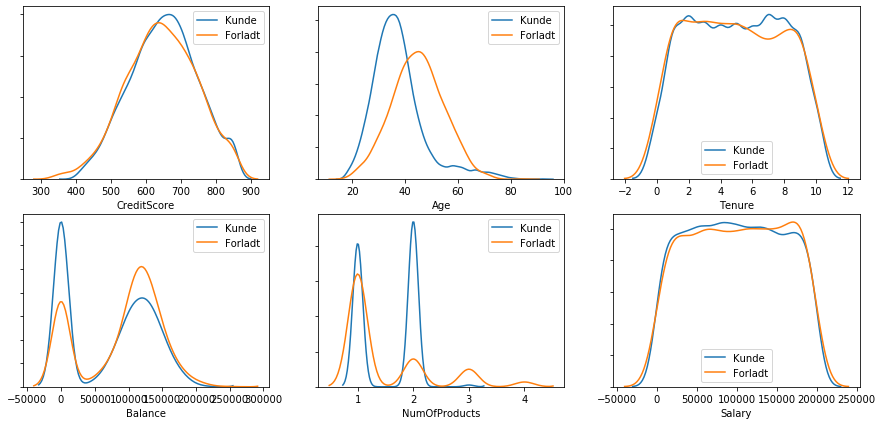

In [12]:
fig, ax = plt.subplots(2,3, figsize=(15,7))
for i in range(2):
    for j in range(3):
        feature = continuous_features[i*3+j]
        df_churned = df_data[df_data['Churned'] == 1][feature]
        df_unchurned = df_data[df_data['Churned'] == 0][feature]
        sns.distplot(df_unchurned, ax=ax[i][j], hist=False, label='Kunde')
        sns.distplot(df_churned, ax=ax[i][j], hist=False, label='Forladt')
        ax[i][j].set_yticklabels([])

Tanker:
- Churned 

### Balanceret

Det næste ting som jeg plejer at kigge på er om data er balaceret.

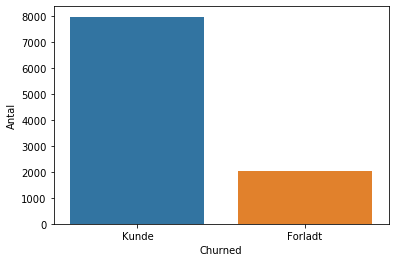

In [13]:
ax = sns.countplot(df_data['Churned'])
ax.set_xticklabels(['Kunde', 'Forladt'])
ax.set_ylabel('Antal');

In [14]:
total = len(df_data['Churned'])
churned_count = len(df_data[df_data['Churned'] == 1])
churned_pct = (churned_count / total) * 100
print('{0:0.2f} % af kunder har sagt farvel!'.format(churned_pct))

20.37 % af kunder har sagt farvel!


Fordelingen er 1:4. Vi kan ikke bruge accuracy. Vi skal bruge F1 score og ROC area under curve.

Der er to udfordringer som vi skal løst:
1. ubalceret data øger risikoen for at vores model performer dårlig fordi den bliver biased mod den store klasse dvs. minoritetsklassen bliver ikke modeleret godt
2. omkostningen ved at prædiktere forkert på kunder der er ved at forlade banken er højere end en forkert prediktion i den omvendte situation
   - hvis modellen prædikterer at en kunde vil blive mens kunden er på vej ud så er det en større fejl end hvis modellen prædiktere at en kunde er på vej ud men i virkligheden vil kunden slet ikke nogen steder
   - derfor skal modellen ikke lave type

Lunar har mere interesse i kunder, der er på vej ud.


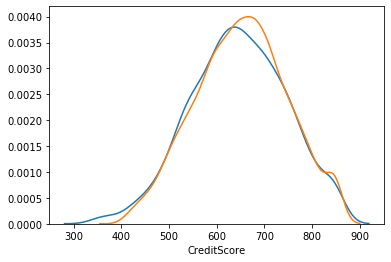

In [15]:
#fig, ax = plt.subplots(1,2, figsize=(7,4))
sns.distplot(df_data[df_data['Churned'] == 1]['CreditScore'], hist=False)
sns.distplot(df_data[df_data['Churned'] == 0]['CreditScore'], hist=False)

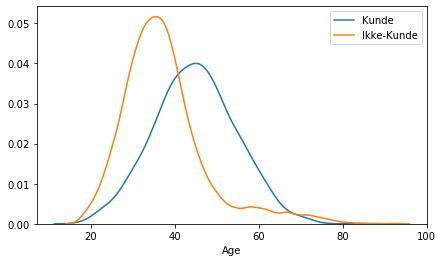

In [16]:
fig, ax = plt.subplots(figsize=(7,4))
sns.distplot(df_data[df_data['Churned'] == 1]['Age'], hist=False, label='Kunde', ax=ax)
sns.distplot(df_data[df_data['Churned'] == 0]['Age'], hist=False, label='Ikke-Kunde', ax=ax)

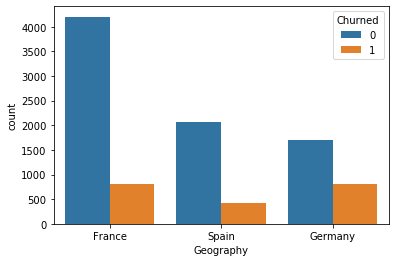

In [17]:
sns.countplot(x='Geography', hue='Churned', data=df_data)

## Klargøring af data

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
df_data.dtypes

UserId              int64
LastName           object
CreditScore         int64
Geography          object
Gender             object
Age                 int64
Tenure              int64
Balance           float64
NumOfProducts       int64
HasCreditCard       int64
IsActiveMember      int64
Salary            float64
Churned             int64
dtype: object

In [20]:
y = np.array(df_data[['Churned']])

In [21]:
y

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [22]:
X = df_data.copy()[boolean_features + continuous_features]
X = pd.concat([X, pd.get_dummies(df_data[categorical_features])], axis=1)

In [23]:
X.head()

,HasCreditCard,IsActiveMember,CreditScore,Age,Tenure,Balance,NumOfProducts,Salary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
Index,,,,,,,,,,,,,
1,1,1,619,42,2,0.00,1,101348.88,1,0,0,1,0
2,0,1,608,41,1,83807.86,1,112542.58,0,0,1,1,0
3,1,0,502,42,8,159660.80,3,113931.57,1,0,0,1,0
4,0,0,699,39,1,0.00,2,93826.63,1,0,0,1,0
5,1,1,850,43,2,125510.82,1,79084.10,0,0,1,1,0


In [24]:
scaler = StandardScaler()

Mange ML modeller kræver at features er normaliseret eller skaleret. Der er forskellige feature skaleringer:
- [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html): er godt hvis man ens feature er normalt fordelt
- 
- [RobustScaler](https://scikit-learn.org/stable/modules/preprocessing.html#scaling-data-with-outliers): når data indeholder mange outliers

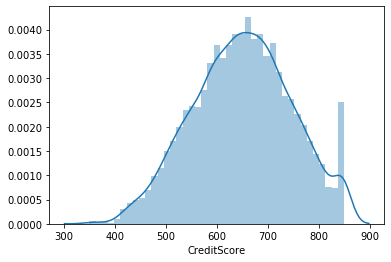

In [25]:
sns.distplot(X['CreditScore'])

In [26]:
scaler.fit_transform(X['CreditScore'].values.reshape(-1, 1))

array([[-0.32622142],
       [-0.44003595],
       [-1.53679418],
       ...,
       [ 0.60498839],
       [ 1.25683526],
       [ 1.46377078]])

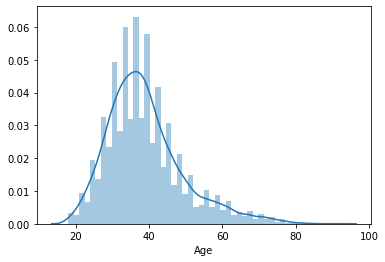

In [27]:
sns.distplot(X['Age'])

In [28]:
scaler.fit_transform(X['Age'].values.reshape(-1, 1))

array([[ 0.29351742],
       [ 0.19816383],
       [ 0.29351742],
       ...,
       [-0.27860412],
       [ 0.29351742],
       [-1.04143285]])

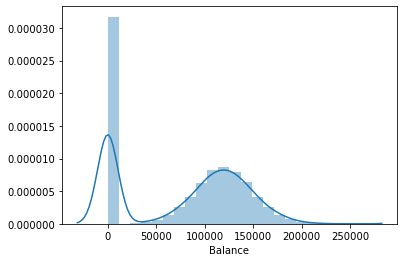

In [29]:
sns.distplot(X['Balance'])

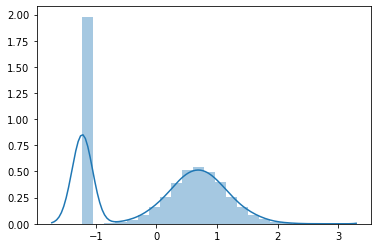

In [30]:
sns.distplot(scaler.fit_transform(X['Balance'].values.reshape(-1, 1)))

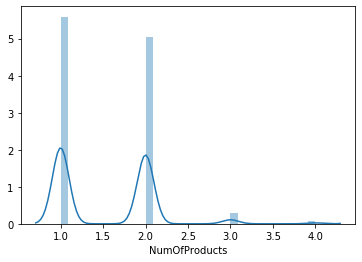

In [31]:
sns.distplot(X['NumOfProducts'])

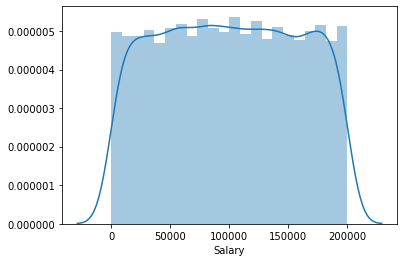

In [32]:
sns.distplot(X['Salary'])

### Hvorfor skifter man bank?

Mybankers [bankundersøgelse](https://www.mybanker.dk/artikler/hver-fjerde-dansker-har-skiftet-bank-de-seneste-5-aar/) i 2018 viser flg.:

| Årsager til ikke at skifte bank (flere svar) | %   |
|----------------------------------------------|-----|
| Tror ikke bedre vilkår er muligt             | 70% |
| Det kræver meget tid og energi               | 34% |
| Ny netbank, dankort, kode og kontonumre      | 33% |
| Ny rådgiver                                  | 17% |
| Mange omkostninger                           | 12% |
| At det er for kompliceret                    | 11% |
| Går bag om ryggen på nuværende bank          | 2%  |

| Årsag til overvejet bankskifte  | %   |
|---------------------------------|-----|
| Priser / Gebyrer / Renter       | 65% |
| Rådgivning - Kvalitet           | 29% |
| Værdier                         | 19% |
| Lokale filialer                 | 14% |
| Kemi med personalet             | 11% |
| Service                         | 10% |
| Teknologi - netbank / mobilbank | 7%  |

3052 besvarelser indsamlet feb 2018 til apr 2018 (3 mdr). Indsamlet Mybankers sociale mediekanaler og abonnenter af Mybankers nyhedsbrev. Kun 19 banker indgår i analysen.

## Andre data som kunne være relevant?

- Dataene er en snapshot. Hvad betyder det?
- Transkationer så i stedet for `IsActiveMember` så kan man måske grader hvor aktiv kunden er. Det kunne give mere information
- Istedet for `NumOfProducts` hvilke produkter har kunderne købt  kunne give mere information 
- Kunder som ikke exited but still have a balance in their account! What would this mean? Could they have exited from a product and not the bank?
- Mangler noget kontekst for dataene. Hvordan dataene er trukket ud og konteks omkring data kunne gøre man har en bedre forståelse for hvordan man skal lave modeller.